#Mouafak Alsaid Hasan
## Expectation-Maximization Clustering

##Lib Import

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import math
import scipy.spatial as spa
import matplotlib.patches as mp




##Data Generation

In [38]:
#definitions of covarience matrices for all sub_samples               
def create_cov(A, B):
  return [A, B]

#an array containing the size of each sub-sample.
sizes = np.array([50, 50, 50, 50, 100])
#an array containing mean vectors.
mean = np.array([[+2.5, +2.5], [-2.5, +2.5], [-2.5, -2.5], [+2.5, -2.5], [0.0, 0.0]])





#covarience matrices
cov_matrices = np.array([create_cov([+0.8, -0.6], [-0.6, +0.8]),
                         create_cov([+0.8, +0.6], [+0.6, +0.8]),
                         create_cov([+0.8, -0.6], [-0.6, +0.8]),
                         create_cov([+0.8, +0.6], [+0.6, +0.8]),
                         create_cov([+1.6, 0.0], [0.0, +1.6])  ])

print(cov_matrices[0])
#bivariate Gaussian data generation
data_1 = np.random.multivariate_normal(mean[0], cov_matrices[0], sizes[0])
data_2 = np.random.multivariate_normal(mean[1], cov_matrices[1], sizes[1])
data_3 = np.random.multivariate_normal(mean[2], cov_matrices[2], sizes[2])
data_4 = np.random.multivariate_normal(mean[3], cov_matrices[3], sizes[3])
data_5 = np.random.multivariate_normal(mean[4], cov_matrices[4], sizes[4])
data = np.concatenate((data_1, data_2, data_3, data_4, data_5))


#size of data and number of clusters.
N = len(data)
K = 5





[[ 0.8 -0.6]
 [-0.6  0.8]]


##Data Plot

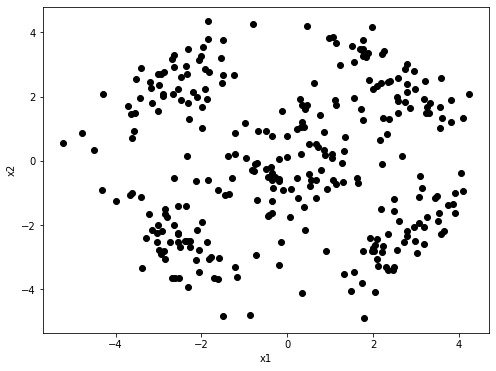

In [39]:
#Plotting the data points
plt.figure(figsize=(8,6))
plt.plot(data_1[:, 0], data_1[:, 1], "b.", markersize= 12, color = 'black')
plt.plot(data_2[:, 0], data_2[:, 1], "b.", markersize= 12, color = 'black')
plt.plot(data_3[:, 0], data_3[:, 1], "b.", markersize= 12, color = 'black')
plt.plot(data_4[:, 0], data_4[:, 1], "b.", markersize= 12, color = 'black')
plt.plot(data_5[:, 0], data_5[:, 1], "b.", markersize= 12, color = 'black')
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()

##K-mean Clustering Algorithm

In [40]:
def update_centroids(memberships, X):
    if memberships is None:
        # initialize centroids
        centroids = X[np.random.choice(range(N), K),:]
    else:
        # update centroids
        centroids = np.vstack([np.mean(X[memberships == k,], axis = 0) for k in range(K)])
    return(centroids)

def update_memberships(centroids, X):
    # calculate distances between centroids and data points
    D = spa.distance_matrix(centroids, X)
    # find the nearest centroid for each data point
    memberships = np.argmin(D, axis = 0)
    return(memberships)

# K-means for 2 iterations

centroids = None
memberships = None
centroids = update_centroids(memberships, data)
iteration = 0
while iteration < 2:
    
    old_centroids = centroids
    centroids = update_centroids(memberships, data)
    old_memberships = memberships
    memberships = update_memberships(centroids, data)
    iteration = iteration + 1

print(centroids)




[[ 1.32994747 -1.08622765]
 [ 2.29850823  2.41662191]
 [-2.0971908   2.88639639]
 [-2.31645583 -2.4425403 ]
 [-3.10487533  1.48637144]]


##Expectation Maximization Algorithm

In [46]:

#methods for covariance matrix
def initialize_cov(X, Y, mean, K):
  denomenator = np.sum(Y)
  numerator = create_cov([0.0, 0.0],[0.0, 0.0])
  for j in range(len(X)):
    point = np.reshape(X[j] - mean, (2,1))
    numerator = numerator + np.multiply( Y[j], np.matmul(point, np.transpose(point)))
  return np.array(numerator/denomenator)



def update_cov_matrix(X, Y, mean, K):
  return np.array([initialize_cov(X, Y[c], mean[c], K) for c in range(K)])

#method for means
def update_mean(X, Y, K):
  means = []
  for i in range(K):
    sum = [0.0, 0.0]
    denom = 0.0
    for j in range (len(X)):
      sum += np.multiply(Y[i][j], X[j])
      denom += Y[i][j]
    means.append(np.multiply(1/denom, sum))
  return np.array(means)


#methods to initialize and update priors
def initialize_priors(Y, N, K):
  priors = []
  for i in range(K):
    sum = 0
    for j in range(N):
      if i == Y[j]:
        sum +=1
    priors.append(sum/N)    
  return np.array(priors)


def update_prior(Y, N, K):
  return np.array([(np.sum(Y[c])/N) for c in range(K)])

#methods for memberships
def membership_hik(x, mean, cov, priors, c, K):
  numerator = np.multiply(priors[c], stats.multivariate_normal.pdf(x, mean[c], cov[c]))
  denomenator = 0.0
  for i in range(K):
    denomenator += np.multiply(priors[i], stats.multivariate_normal.pdf(x, mean[i], cov[i]))
  return numerator / denomenator

def class_membership(X, mean, cov, priors,  K):
  membership = [[], [], [], [], []]
  for i in range(K):
    for j in range(len(X)):
      membership[i].append(membership_hik(X[j], mean, cov, priors,  i, K))
  return np.array(membership)

     
priors = initialize_priors(memberships, N, K)
initial_mean = centroids
initial_labels = np.array([memberships for c in range(K)])

cov = update_cov_matrix(data, initial_labels, initial_mean, K)
Z = class_membership(data, initial_mean, cov, priors, K)
iteration = 0

while iteration < 100:

  priors = update_prior(Z, N, K)
  initial_mean = update_mean(data, Z, K)
  cov = update_cov_matrix(data,Z, initial_mean, K)
  Z = class_membership(data, initial_mean, cov, priors, K)
  iteration +=1


print("after the 100 iteration")
print(initial_mean)


def predict(Y, K, N):
  pred = [0 for i in range(N)]
  point_1 = Y[0]
  point_2 = Y[1]
  point_3 = Y[2] 
  point_4 = Y[3] 
  point_5 = Y[4]
  for j in range(N):
    if point_1[j] > point_2[j] and point_1[j] > point_3[j] and point_1[j] > point_4[j] and point_1[j] > point_5[j]:
      pred[j] = 0
    if point_2[j] > point_1[j] and point_2[j] > point_3[j] and point_2[j] > point_4[j] and point_2[j] > point_5[j]:
      pred[j] = 1
    if point_3[j] > point_1[j] and point_3[j] > point_2[j] and point_3[j] > point_4[j] and point_3[j] > point_5[j]:
      pred[j] = 2
    if point_4[j] > point_1[j] and point_4[j] > point_2[j] and point_4[j] > point_3[j] and point_4[j] > point_5[j]:
      pred[j] = 3
    if point_5[j] > point_1[j] and point_5[j] > point_2[j] and point_5[j] > point_3[j] and point_5[j] > point_4[j]:
      pred[j] = 4
  return np.array(pred)


      

Y_predicted = predict(Z,K,N)

  







after the 100 iteration
[[ 0.98494246 -0.8036208 ]
 [ 2.48568387  2.56809781]
 [-2.84606553  2.44613252]
 [-2.5544433  -2.56424348]
 [-1.90620897  2.11172063]]


##Plot of EM Algorithm's Results

[[[ 2.69234256 -0.95675124]
  [-0.95675124  2.67029151]]

 [[ 0.74943026 -0.59117205]
  [-0.59117205  0.7107561 ]]

 [[ 0.80194951  0.70192167]
  [ 0.70192167  0.87695377]]

 [[ 0.49702731 -0.44777491]
  [-0.44777491  0.84267305]]

 [[ 0.12052793  0.1096884 ]
  [ 0.1096884   0.15195895]]]


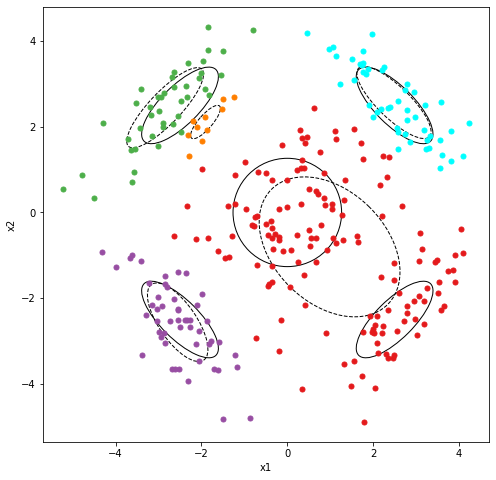

In [47]:
cluster_colors = np.array(["#e41a1c", 'cyan', "#4daf4a", "#984ea3", "#ff7f00"])

figure = plt.figure(figsize=(8,8))
axis = figure.gca()

for c in range(K):
  plt.plot(data[Y_predicted == c, 0], data[Y_predicted == c, 1], ".", markersize = 10, color = cluster_colors[c])



def normal_elipce(x):
    mean, x, Vt = np.linalg.svd(x)
    angle = np.degrees(np.arctan2(mean[1, 0], mean[0, 0]))
    width, height = 2 * np.sqrt(x)
    return angle, width, height
 
print(cov)
for c in range(K):
   angel, width, height = normal_elipce(cov_matrices[c])
   orginal_elipce = mp.Ellipse(xy=mean[c], width=width, height=height, angle=angel,edgecolor='black', facecolor='none', linestyle='solid')
   axis.add_artist(orginal_elipce)
   

for c, covar in zip(initial_mean, cov):
   estimated_ang, es_width, es_height = normal_elipce(covar)
   estimated_elipce = mp.Ellipse(xy=c, width= es_width, height= es_height, angle=estimated_ang, edgecolor='black', facecolor='none', linestyle='dashed')
   axis.add_artist(estimated_elipce)
   



plt.ylabel('x2')
plt.xlabel('x1')
plt.show()
